# Running Machine Learning algorithms

Neural Network/ Naive Bayes


In [2]:
import json
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from scipy.sparse import csr_matrix, coo_matrix, hstack, vstack, save_npz,  load_npz
from functools import reduce

import keras

print(keras.__version__)

2.9.0


### Load dataset 

In [3]:
ym = np.load("data/train_P4_md.npy")
Xm = load_npz("data/train_P4_md_X.npz")
yc = np.load("data/train_P4_code.npy")
Xc = load_npz("data/train_P4_code_X.npz")

In [8]:
print(Xm.shape,ym.shape,Xc.shape,yc.shape)
print(type(Xm),type(ym),type(Xc),type(yc))

(89294, 434) (89294,) (243888, 500) (243888,)
<class 'scipy.sparse._csr.csr_matrix'> <class 'numpy.ndarray'> <class 'scipy.sparse._csr.csr_matrix'> <class 'numpy.ndarray'>


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, log_loss, accuracy_score, precision_score, roc_curve

In [11]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc,
                                                       shuffle = True,
                                                       random_state = 137,
                                                       test_size = .2)

In [42]:
print(Xc_train.shape, Xc_test.shape, yc_train.shape, yc_test.shape)
print(type(Xc_train), type(Xc_test), type(yc_train), type(yc_test))

(195110, 500) (48778, 500) (195110,) (48778,)
<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Gaussian Naive Bayes


In [16]:
gnb =  GaussianNB()
gnb.fit(Xc_train.toarray(),yc_train)


GaussianNB()

In [20]:
yc_predict = gnb.predict(Xc_test.toarray())

array([ True, False, False, ..., False, False, False])

In [50]:
def textoutput(ytest, ypred):
     yc_correctness = (ytest==ypred)
     print("#correct", yc_correctness.sum(), "total num", yc_correctness.size)
     print("Mean Sq Error: ",round(mean_squared_error(ytest*1, 1*ypred),3),
          "X Entropy error: ", round(log_loss(ytest*1, 1*ypred),4))
     print("Accuracy Score: ",round(accuracy_score(ytest*1, 1*ypred),4),
          "Precision Score: ", round(precision_score(ytest*1, 1*ypred),4))

textoutput(yc_test, yc_predict)

#correct 30777 total num 48778
Mean Sq Error:  0.369 X Entropy error:  12.7463
Accuracy Score:  0.631 Precision Score:  0.6216


## Neural Network

Reference
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
https://scikit-learn.org/stable/modules/neural_networks_supervised.html#mlp-tips

In [58]:
mlp = MLPClassifier(solver='sgd', alpha=1e-3,
                    activation="logistic", learning_rate_init=0.01,
                        hidden_layer_sizes=(20, 20), random_state=137)
mlp.fit(Xc_train.toarray(),yc_train)

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPClassifier(activation='logistic', alpha=0.001, hidden_layer_sizes=(20, 20),
              learning_rate_init=0.01, random_state=137, solver='sgd')

In [54]:
yc_predict_mlp = mlp.predict(Xc_test.toarray())
textoutput(yc_test, yc_predict_mlp)

#correct 36869 total num 48778
Mean Sq Error:  0.244 X Entropy error:  8.4326
Accuracy Score:  0.7559 Precision Score:  0.7582


In [59]:
rfc = RandomForestClassifier()
rfc.fit(Xc_train.toarray(),yc_train)

RandomForestClassifier()

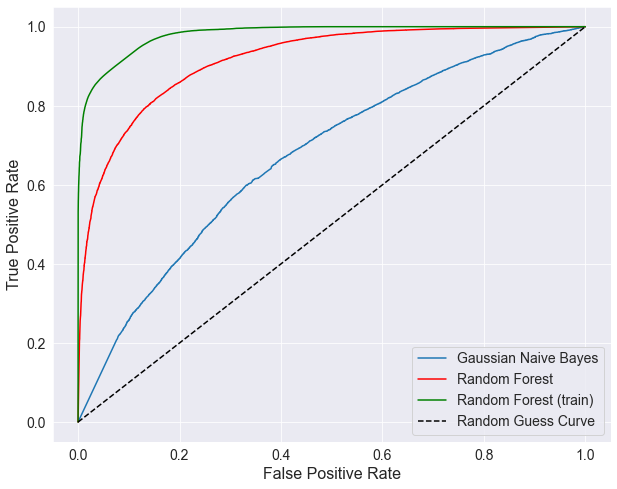

In [61]:
fprs1, tprs1, cutoffs1 = roc_curve(np.array(yc_test), gnb.predict_proba(Xc_test.toarray())[:,1])
fprs2, tprs2, cutoffs2 = roc_curve(np.array(yc_test), rfc.predict_proba(Xc_test.toarray())[:,1])
fprs3, tprs3, cutoffs3 = roc_curve(np.array(yc_train), rfc.predict_proba(Xc_train.toarray())[:,1])
plt.figure(figsize=(10,8))

plt.plot(fprs1, tprs1, label="Gaussian Naive Bayes")
plt.plot(fprs2, tprs2, "r", label="Random Forest")
plt.plot(fprs3, tprs3, "g", label="Random Forest (train)")
plt.plot([0,1], [0,1], 'k--', label="Random Guess Curve")


plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.show()

In [49]:
Yc_predict_prob = gnb.predict_proba(Xc_test.toarray())

### Kendal Tau 

This is described in another notebook

In [2]:
from bisect import bisect


# Actually O(N^2), but fast in practice for our data
def count_inversions(a):
    inversions = 0
    sorted_so_far = []
    for i, u in enumerate(a):  # O(N)
        j = bisect(sorted_so_far, u)  # O(log N)
        inversions += i - j
        sorted_so_far.insert(j, u)  # O(N)
    return inversions

Here is the formula, where $S_i$  is the number of inversions in the predicted ranks and $n_i$ is the number of cells for notebook $i$

$K=1-4 \frac{\sum_i S}{\sum_i n (n-1)}$ 

In [6]:
def kendall_tau(ground_truth, predictions):
    total_inversions = 0  # total inversions in predicted ranks across all instances
    total_2max = 0  # maximum possible inversions across all instances
    for gt, pred in zip(ground_truth, predictions):
        ranks = [gt.index(x) for x in pred]  # rank predicted order in terms of ground truth
        total_inversions += count_inversions(ranks)
        n = len(gt)
        total_2max += n * (n - 1)
    return 1 - 4 * total_inversions / total_2max

In [7]:
import random
testlist = [["ukraine", "UK", "spain", "sweden", "serbia", "italy"],] #eurovision 2022
shuffled_list=[]
for l in testlist:
    shuffled_list.append(l.copy())
    random.shuffle(shuffled_list[-1])

In [8]:
shuffled_list

[['UK', 'italy', 'serbia', 'spain', 'sweden', 'ukraine']]

In [9]:
kendall_tau(testlist, shuffled_list)

-0.33333333333333326